# Imports & Drive Mounting

In [ ]:
# import
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from sklearn.tree import DecisionTreeClassifier


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
PS = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Read data & save as train_csv

In [ ]:
# read txt as csv
train_data = pd.read_csv("/content/drive/MyDrive/Datasets/Movie_Genre_Classifications/train_data.txt", sep=':::', names=["id", "title", "genre", "description"], engine='python')
train_data.to_csv('/content/drive/MyDrive/Datasets/Movie_Genre_Classifications/train_csv.csv')

In [ ]:
train_data.head(5)

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


#Exploring data

In [ ]:
train_data.isnull().sum()

id             0
title          0
genre          0
description    0
dtype: int64

In [ ]:
# Get the unique values in Genre column
print('No. unique values in genre',train_data.genre.nunique())
train_data.genre.value_counts()

No. unique values in genre 27


genre
 drama           799
 documentary     749
 comedy          441
 short           315
 horror          129
 thriller        112
 action           80
 reality-tv       60
 western          59
 family           47
 adult            43
 adventure        42
 sci-fi           42
 music            37
 romance          32
 animation        27
 biography        25
 crime            23
 sport            19
 fantasy          17
 talk-show        16
 mystery          15
 history          14
 game-show        12
 musical           9
 news              7
 war               7
Name: count, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, ' drama '),
  Text(1, 0, ' documentary '),
  Text(2, 0, ' comedy '),
  Text(3, 0, ' short '),
  Text(4, 0, ' horror '),
  Text(5, 0, ' thriller '),
  Text(6, 0, ' action '),
  Text(7, 0, ' reality-tv '),
  Text(8, 0, ' western '),
  Text(9, 0, ' family ')])

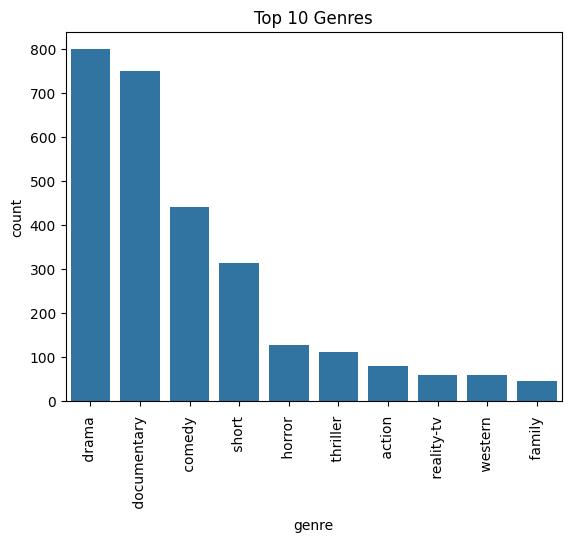

In [ ]:
# Plot top 10 genres by count
top_10_genre = pd.DataFrame(train_data.genre.value_counts()).reset_index().head(10)
sns.barplot(x='genre',y='count',data=top_10_genre).set(title='Top 10 Genres')
plt.xticks(rotation=90)


# Do some opration in description column

In [ ]:
# we have did it in import section

# nltk.download('stopwords')
# nltk.download('punkt')
# PS = PorterStemmer()
# stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
# create a column called desc_len which shows len of description column
train_data['desc_len'] = train_data['description'].apply(len)
print("Max len of description: ",train_data['desc_len'].max())
print("Min len of description: ",train_data['desc_len'].min())
train_data['desc_len'].head(10)


Max len of description:  10504
Min len of description:  77


0     546
1     184
2     650
3    1082
4     625
5    1609
6     345
7     332
8     456
9     426
Name: desc_len, dtype: int64

In [ ]:
# Function for dEscription filtering
def desc_filter(desc):
  desc = desc.lower()
  desc = re.sub(r'@\S+','',desc)
  desc = re.sub(r'http\S+', '', desc)
  desc = re.sub(r'[\w\.-]+@[\w\.-]+',"",desc)
  desc = re.sub(r"[^a-zA-Z+']", ' ', desc)
  desc = re.sub('-',' ',desc.lower())
  desc = re.sub(r'\'', '',desc)
  word_tokens = word_tokenize(desc)
  stpWrd_removal = []
  filtered_article = []
  for word in word_tokens:
    if word not in stopwords:
       stpWrd_removal.append(word)
  for i in stpWrd_removal:
    filtered_article.append(PS.stem(i))
  # print("stpWrd_removal list: ",stpWrd_removal)
  # print("filtered_article list: ",filtered_article)
  return ' '.join(filtered_article)

In [ ]:
# Column of preprocessed txt
train_data['filterd_desc'] = train_data.description.apply(desc_filter)

In [ ]:
train_data['filterd_desc'].head(10)

0    listen convers doctor parent year old oscar le...
1    brother sister past incestu relationship curre...
2    bu empti student field trip museum natur histo...
3    help unemploy father make end meet edith twin ...
4    film titl refer un recov bodi ground zero also...
5    qualiti control consist seri mm singl take sho...
6    tough econom time max joey run idea discov sen...
7    ron petri keanu reev troubl teen whose life ha...
8    sudden calamit event caus great loss life dama...
9    four high school student embark terrifi journe...
Name: filterd_desc, dtype: object

In [ ]:
# column for preprocessed txt length
train_data['filterd_desc_len'] = train_data['filterd_desc'].apply(len)
train_data['filterd_desc_len'].head(10)
print("Filtered max len: ",train_data['filterd_desc_len'].max())
print("Filtered min len: ",train_data['filterd_desc_len'].min())

Filtered max len:  6403
Filtered min len:  58


In [ ]:
# get the length greater than 2000 in filterd desc
print("val >1000",(train_data['filterd_desc_len']>1000).value_counts())
print('--------------------------------')
print("val >3000",(train_data['filterd_desc_len']>3000).value_counts())
print('--------------------------------')
print("val >5000",(train_data['filterd_desc_len']>5000).value_counts())

val >1000 filterd_desc_len
False    3073
True      105
Name: count, dtype: int64
--------------------------------
val >3000 filterd_desc_len
False    3177
True        1
Name: count, dtype: int64
--------------------------------
val >5000 filterd_desc_len
False    3177
True        1
Name: count, dtype: int64


In [ ]:
# remove the rows that the length greater than 2000 in preprocessed description
# train_df = train_df[~(train_df['Processed Desc length']>2000)]

In [ ]:
# Label Encoding for Genre column
lbl_encod = LabelEncoder()
lbl_encod.fit(train_data['genre'])
train_data['genre_lbl_encod'] = lbl_encod.transform(train_data['genre'])
train_data.head(5)

,id,title,genre,description,desc_len,filterd_desc,filterd_desc_len,genre_lbl_encod
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,546,listen convers doctor parent year old oscar le...,339,8
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,184,brother sister past incestu relationship curre...,111,24
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,650,bu empti student field trip museum natur histo...,344,1
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,1082,help unemploy father make end meet edith twin ...,678,8
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,625,film titl refer un recov bodi ground zero also...,350,8


In [ ]:
# for future use
lbl_encod.inverse_transform([24])

array([' thriller '], dtype=object)

In [ ]:
print('Average length of a description before preprocess',train_data['desc_len'].mean())
print('Average length of a description after preprocess',train_data['filterd_desc_len'].mean())

Average length of a description before preprocess 607.9443045940843
Average length of a description after preprocess 367.44713656387665


In [ ]:
# # Stop word removal
# eng_stpwrd = set(stopwords.words('english'))

# def stopWordFilter(plot):
#     filtered = [x for  x in plot.split() if not x in eng_stpwrd]
#     return ' '.join(filtered)

# train_data['description_new'] = train_data['description'].apply(lambda x : stopWordFilter(x))



              word  Frequency
16             the      17754
8              and      11329
59              of       9967
3                a       9618
2               to       9314
...            ...        ...
24764        burn.          1
24763    ambition.          1
24762      Monkees          1
24761     Monkees.          1
48955  discovered,          1

[48956 rows x 2 columns]


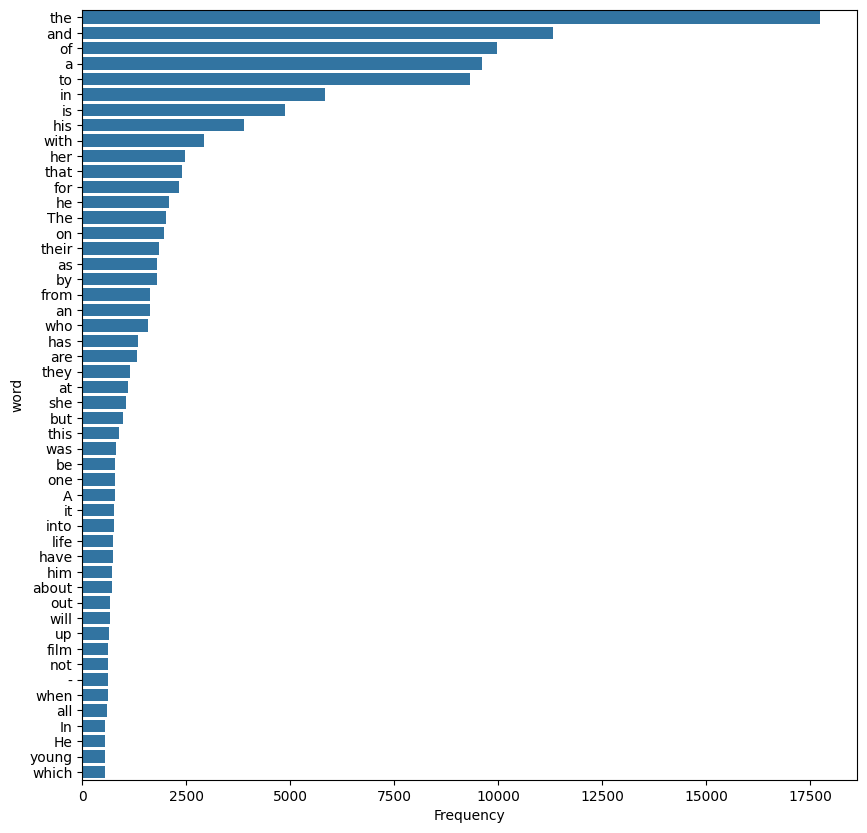

In [ ]:
def WordFreqConter(col, items):
  txt = ' '.join([plot for plot in col])
  txt = txt.split()
  frq_dist = nltk.FreqDist(txt)
  word_df = pd.DataFrame({'word': list(frq_dist.keys()), 'Frequency':list(frq_dist.values())})

  order = word_df.nlargest(columns='Frequency', n=items)
  print(word_df.sort_values(by='Frequency',ascending=False))
  plt.figure(figsize=(10,10))
  ax = sns.barplot(data=order, x='Frequency', y='word')
  plt.show()

WordFreqConter(train_data['description'],50)

In [ ]:
# Spliting the data for prediction
# X = train_df['Processed Description']
# y = train_df['genre_le']

X , y = train_data['filterd_desc'], train_data['genre_lbl_encod']

In [ ]:
# Vectorization on description column using Tf idf Vectorizer
vactorizer = TfidfVectorizer()
x = vactorizer.fit_transform(X)
X_vactor = x.toarray()

In [ ]:
# DataFrame after Vectorization

pd.DataFrame(data=X_vactor , columns = vactorizer.get_feature_names_out())

,aaa,aalto,aarav,aarohi,aaron,aarti,ab,aba,abandon,abandonado,...,zudak,zuleiia,zuleika,zulkifli,zumba,zurich,zuzana,zwart,zwei,zwick
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Model Building

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_vactor,y,test_size=0.2, random_state=42)
X_train.shape

(2542, 18928)

> LR Model

In [ ]:
lr_model = LogisticRegression(penalty='l1',solver='liblinear',C=1.0)
lr_model.fit(X_train, y_train)

print("Scores",lr_model.score(X_train,y_train), lr_model.score(X_test, y_test))

Scores 0.4752163650668765 0.43553459119496857


**penalty='l1': This parameter specifies the regularization penalty to be applied. In this case, 'l1' refers to L1 regularization, which penalizes the absolute values of the model coefficients.**

**solver='liblinear': This parameter specifies the solver algorithm to use for optimization. In this case, 'liblinear' is specified, which is a type of solver suitable for small datasets.**

**C=1.0: This parameter specifies the strength of the regularization penalty. A higher value of C indicates less regularization, while a lower value indicates more regularization. In this case, C=1.0 specifies a moderate level of regularization**

In [ ]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.38      0.24      0.30        74
           6       0.00      0.00      0.00         6
           7       0.50      0.79      0.61       160
           8       0.39      0.79      0.52       154
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.25      0.04      0.07        23
          14       0.00      0.00      0.00        16
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00    

> MNB

In [ ]:
mnb_model = MultinomialNB()
mnb_model.fit(X_train,y_train)
mnb_model.score(X_train,y_train),mnb_model.score(X_test,y_test)

(0.4885916601101495, 0.4386792452830189)

In [ ]:
# Classification Report
y_pred = mnb_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.33      0.01      0.03        74
           6       0.00      0.00      0.00         6
           7       0.58      0.85      0.69       160
           8       0.36      0.92      0.51       154
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        16
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00    

> Decision tree


In [ ]:
dct_model = DecisionTreeClassifier(max_depth=8)
dct_model.fit(X_train,y_train)
dct_model.score(X_train,y_train),dct_model.score(X_test,y_test)

(0.43273013375295044, 0.36792452830188677)

In [ ]:
y_pred = dct_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         4
           5       0.61      0.15      0.24        74
           6       0.00      0.00      0.00         6
           7       0.49      0.62      0.55       160
           8       0.30      0.77      0.43       154
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        16
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00    

> **Results**

In [ ]:
accuracy = {'Model':['LR','MNB','DCT'],
            'Accuracy':[43.55,43.86,36.79]}
pd.DataFrame(accuracy)

,Model,Accuracy
0,LR,43.55
1,MNB,43.86
2,DCT,36.79


#Prediction

In [ ]:
# actual : drama
des_drama = "Listening in to a conversation between his doctor and parents, 10-year-old Oscar learns what nobody has the courage to tell him. He only has a few weeks to live. Furious, he refuses to speak to anyone except straight-talking Rose, the lady in pink he meets on the hospital stairs. As Christmas approaches, Rose uses her fantastical experiences as a professional wrestler, her imagination, wit and charm to allow Oscar to live life and love to the full, in the company of his friends Pop Corn, Einstein, Bacon and childhood sweetheart Peggy Blue"
des_thriller = "A brother and sister with a past incestuous relationship have a current murderous relationship. He murders the women who reject him and she murders the women who get too close to him."
des_adult = "As the bus empties the students for their field trip to the Museum of Natural History, little does the tour guide suspect that the students are there for more than just another tour. First, during the lecture films, the coeds drift into dreams of the most erotic fantasies one can imagine. After the films, they release the emotion of the fantasies in the most erotic and uncommon ways. One slips off to the curator's office for a little \"acquisition. \" Another finds the anthropologist to see what bones can be identified. Even the head teacher isn't immune. Soon the tour is over, but as the bus departs, everyone admits it was quite an education."

des_tst0="L.R. Brane loves his life - his car, his apartment, his job, but especially his girlfriend, Vespa. One day while showering, Vespa runs out of shampoo. L.R. runs across the street to a convenience store to buy some more, a quick trip of no more than a few minutes. When he returns, Vespa is gone and every trace of her existence has been wiped out. L.R.'s life becomes a tortured existence as one strange event after another occurs to confirm in his mind that a conspiracy is working against his finding Vespa."
des_tst1 = "Spain, March 1964: Quico is a very naughty child of three belonging to a wealthy middle-class family. Since Cristina's birth, he feels he has lost the privileged position of prince of the house for his eight months old sister. So, with his brother Juan, who is eight years old and is quite disobedient, spend their time committing prank after prank, causing the resulting anger of his mother, the nanny and the old housemaid. The rest of the family members are two much older brothers, his resigned mother and a retrograde father of authoritarian ideas. But many years have passed, and the civil war that won the despot Don Pablo is simply for their children Dads war"
des_tst2="Caught by the Piutes, pony Express Rider Dick Carter falls in love with pretty Dorothy Earle, who belongs to that seemingly endless supply of white girls kidnapped in childhood and raised by Indians. Unfortunately, Dorothy is promised to Bud Osborne, described in a title as \"a renegade white who dominates the simple minds of the savage horde.\" Does Dorothy succeed in taking her own life rather than face an uncertain future with evil Bud? Or does the stalwart Dick rescue her in time?"

In [ ]:
txt = desc_filter(des_tst2)

In [ ]:
x = vactorizer.transform([txt])

In [ ]:
# Model prediction
gen = list(lr_model.predict(x))
pr = lbl_encod.inverse_transform([gen])[0]
print('Predicted Genre is :',pr.upper())

Predicted Genre is :  DRAMA 


as we have mejority in drama and documentary our model gives perdition as drama.